# Data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score,f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve)
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss

import warnings
warnings.filterwarnings('ignore')

In [2]:
base_url = "https://raw.githubusercontent.com/filipecorreia23/Bank-Term-Deposit-Prediction/main/output"

# importing datasets
X_train = pd.read_csv(f"{base_url}/X_train_fe.csv")
X_test = pd.read_csv(f"{base_url}/X_test_fe.csv")
y_train = pd.read_csv(f"{base_url}/y_train.csv")
y_test = pd.read_csv(f"{base_url}/y_test.csv")

print(X_train.shape, X_test.shape)
print(y_train.shape,y_test.shape)

(34554, 20) (8639, 20)
(34554, 1) (8639, 1)


Ensuring that the appropriate columns are of type categorical:

In [3]:
category_cols = ['job', 'marital', 'education', 'contact','age_bin', 'previous_bin', 'poutcome','contact_date',
                 'last_contact_days_bin']

for col in category_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Light GBM

In [4]:
# LightGBM model with minimal configuration
lgb_model = LGBMClassifier()  # default settings for LightGBM

# Fit the model 
lgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)])  # Suppress training output

# Predicting probabilities for the test set
y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

# Converting probabilities to binary predictions
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluation 
accuracy = accuracy_score(y_test, y_pred)
logloss = log_loss(y_test, y_pred_proba)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Log Loss: {logloss:.4f}")

[LightGBM] [Info] Number of positive: 4017, number of negative: 30537
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2194
[LightGBM] [Info] Number of data points in the train set: 34554, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116253 -> initscore=-2.028404
[LightGBM] [Info] Start training from score -2.028404
Accuracy: 0.9060
Log Loss: 0.2045


### Classification report

In [5]:
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      7635
           1       0.62      0.50      0.56      1004

    accuracy                           0.91      8639
   macro avg       0.78      0.73      0.75      8639
weighted avg       0.90      0.91      0.90      8639



The model excels at identifying non-subscribers (Class 0), delivering high precision and recall. However, it faces challenges with correctly identifying subscribers (Class 1), where its recall and F1-score are notably lower. Despite this, it still outperforms other models in handling the smaller class. Even though the overall accuracy is 91%, there’s clear potential to improve predictions for Class 1 to achieve a better balance.

### ROC AUC score

In [6]:
# Predicting probabilities for Class 1
y_test_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

# ROC AUC score
test_auc = roc_auc_score(y_test, y_test_proba_lgb)

print(f"Test AUC: {test_auc:.4f}")



Test AUC: 0.9309


Once again, Test AUC score of 0.9309 indicates that our LightGBM model performs very well in distinguishing between the two classes 

### Confusion Matrix

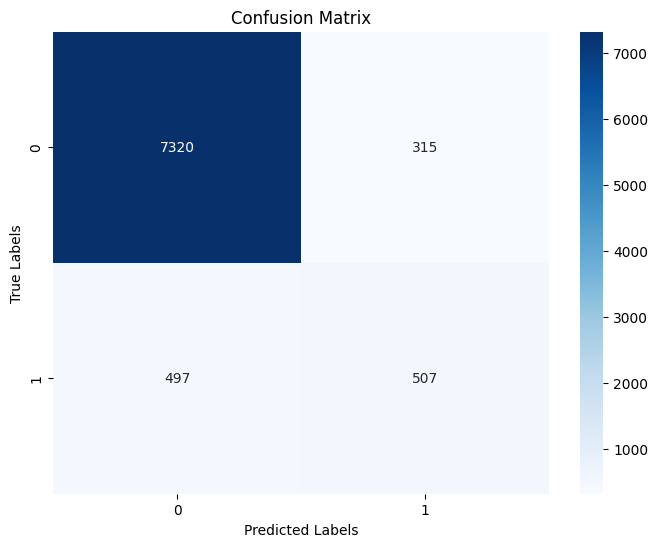

In [7]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix underscores that the model performs exceptionally well in predicting non-subscribers (Class 0) but struggles to accurately identify subscribers (Class 1).

### ROC Curve

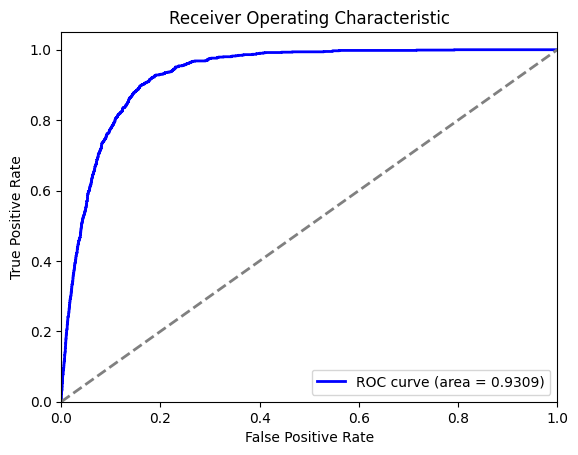

In [8]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba_lgb)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

The curve's closeness to the top-left corner indicates a high true positive rate (sensitivity) combined with a low false positive rate, showcasing the model's strong performance. This analysis demonstrates that the classifier is highly effective for the task and offers opportunities for further optimization of thresholds to align with specific business goals.

### Hyperparameter tuning


In [9]:
# Parameter grid for hyperparameter tuning
param_grid = {
    "learning_rate": [0.01, 0.1, 0.2, 0.3, 0.5],
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10], 
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "n_estimators": [50, 100, 200, 250],
    "max_bin": [255, 512, 1024],
    "num_leaves": [15, 31, 63, 127, 255],
    "min_data_in_leaf": [10, 20, 30, 40, 50],
    "lambda_l1": [0.0, 0.1, 1.0, 5.0, 10.0],  # L1 regularization
    "lambda_l2": [0.0, 0.1, 1.0, 5.0, 10.0],  # L2 regularization
    "min_split_gain": [0.0, 0.01, 0.1, 0.5, 1.0],  # Min loss reduction to split
    "bagging_fraction": [0.4, 0.6, 0.8, 1.0],  # Row sampling
    "bagging_freq": [1, 3, 5, 7],  
    "feature_fraction": [0.4, 0.6, 0.8, 1.0],  # Feature sampling
    "scale_pos_weight": [1.0, 2.0, 3.0, 4.0]  # For imbalanced dataset
}

# Initialization of our model
lgb_model_ = LGBMClassifier(objective='binary', lambda_l1=0.1, lambda_l2=0.1)

# Applying RandomizedSearchCV
random_search = RandomizedSearchCV(
    lgb_model_,
    param_distributions=param_grid,
    n_iter=10,  
    scoring='f1',  # Optimize for f1
    cv=5,  
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
random_search.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],  # Validation set for early stopping
    eval_metric='f1',  # Evaluation metric for early stopping
)

# Best hyperparameters and the best model
best_params_lgb = random_search.best_params_
best_model_lgb = random_search.best_estimator_

# Prediction on the test set
y_pred_lgb = best_model_lgb.predict(X_test)

# Evaluation results 
f1 = f1_score(y_test, y_pred_lgb)
report = classification_report(y_test, y_pred_lgb)

print("Best hyperparameters:", best_params_lgb)
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:\n", report)


/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vect

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fractio

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preproces

[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fractio

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116264 -> initscore=-2.028296
[LightGBM] [Info] Start training from score -2.028296
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Curren

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preproces

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Info] Number of positive: 3214, number of negative: 24429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3901
[LightGBM] [Info] Number of data points in the train s

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preproces

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: ba

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116264 -> initscore=-2.028296
[LightGBM] [Info] Start training from score -2.028296
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[Li

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preproces

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fractio

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Numb

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fractio

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] b

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requireme

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116264 -> initscore=-2.028296
[LightGBM] [Info] Start training from score -2.028296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.7 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Number of positive: 3214, number of negative: 24429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choo

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116232 -> initscore=-2.028607
[LightGBM] [Info] Start training from score -2.028607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.7 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.7 will be ignored. Current value: bagging_fractio

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.7 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.7 will be ignored. Current value: bagging_fractio

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.7 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.7 will be ignored. Current value: bagging_fractio

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.7 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116232 -> initscore=-2.028607
[LightGBM] [Info] Start training from score -2.028607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.7 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Number of positive: 3213, number of negative: 24430
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Inf

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.7 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Number of positive: 3214, number of negative: 24430
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3904
[LightGBM] [Info] Number of data points in the train set

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.9 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Number of positive: 3214, number of negative: 24429
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.9 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Nu

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.9 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Number of positive: 3213, number of negative: 24430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.9 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preproces

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.9 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: ba

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.9 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] lambda_l2 is set=5.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.0
[LightGB

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.9 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning]

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3906
[LightGBM] [Info] Number of data points in the train set: 27643, number of used features: 20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Wa

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preproces

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3904
[LightGBM] [Info] Number of data points in the train set: 27644, number of used features: 20
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3901
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.9 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=1.0, reg

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.9 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116268 -> initscore=-2.028255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -2.028255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.9 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116232 -> initscore=-2.028607
[LightGBM] [Inf

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.9 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] min_data_in_leaf is 

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=10.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=10.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.9 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] min_data_in_leaf is set=40, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=40
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Info] Number of positive: 3214, number of negative: 24430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preproces

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.9 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preproces

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.9 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Number of positive: 3213, number of negative: 24430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory

/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/apple/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=0.9 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=10.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10.0
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116264 -> initscore=-2.028296
[LightGBM] [Info] Start training from score -2.028296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

### Classification report

In [10]:
report = classification_report(y_test, y_pred_lgb)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.91      0.94      7635
           1       0.52      0.75      0.61      1004

    accuracy                           0.89      8639
   macro avg       0.74      0.83      0.77      8639
weighted avg       0.91      0.89      0.90      8639



The report above indicates that the model has not improved much. Perhaps, selecting appropriate features might resolve the issue 

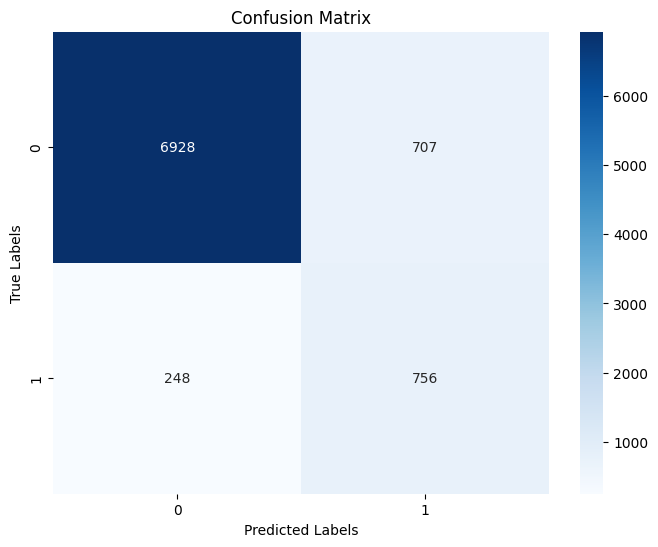

In [11]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_lgb)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.7 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Test AUC: 0.9315


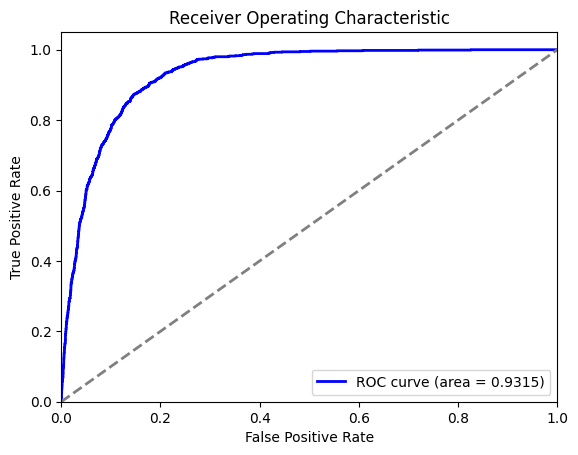

In [12]:
# Predicting probabilities for Class 1
y_test_proba_lgb = best_model_lgb.predict_proba(X_test)[:, 1]

# AUC
test_auc = roc_auc_score(y_test, y_test_proba_lgb)
print(f"Test AUC: {test_auc:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba_lgb)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Feature selection

Lets investigate which features contribute the most to our LGBM model. We will select based on *permutation importance*

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.7 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightG

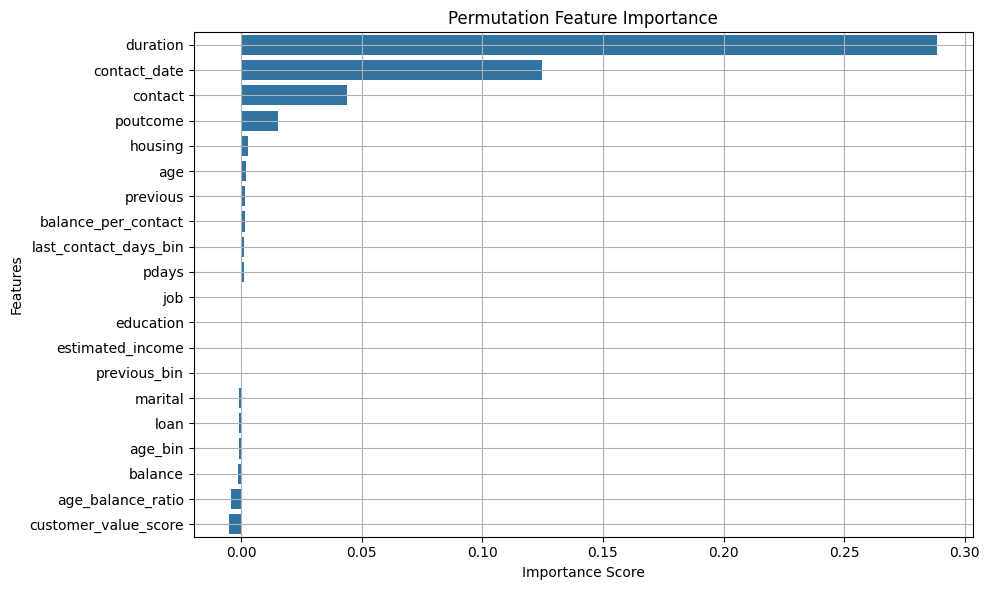

In [13]:
# permutation importance
perm_importance = permutation_importance(best_model_lgb, X_test, y_test, scoring="f1", 
                                         n_repeats=10, random_state=42)

# to convert into df
perm_feature_scores = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm_importance.importances_mean
    }).sort_values(by="Importance", ascending=False)

# plot permutation importance
plt.figure(figsize=(10, 6))
sns.barplot(x=perm_feature_scores["Importance"], y=perm_feature_scores["Feature"])
plt.title("Permutation Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Calculating permutation importance
perm_result = permutation_importance(
    best_model_lgb, 
    X_test, 
    y_test, 
    scoring='f1', 
    n_repeats=10, 
    random_state=42
)

# Converting permutation importance results to a DataFrame
perm_importance = pd.DataFrame({
    'feature': X_test.columns,  # Column names
    'perm_importance': perm_result.importances_mean  # Mean importance scores
})

# importance threshold
perm_threshold = 0.01
top_features = perm_importance[perm_importance['perm_importance'] > perm_threshold]['feature'].tolist()

# Filter to include only important features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

print("Selected Features:")
print(top_features)


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.7 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightG

In [15]:
best_model_lgb_selected = LGBMClassifier(
    **best_params_lgb,  # Use the best hyperparameters found
    
)

# Retrain the model with selected features
best_model_lgb_selected.fit(X_train_selected, y_train)

# Predict on the test set with selected features
y_pred_selected = best_model_lgb_selected.predict(X_test_selected)


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.7 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.7 will be ignored. Current value: bagging_fractio

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [16]:
# Evaluation
f1 = f1_score(y_test, y_pred_selected, pos_label=1)
report = classification_report(y_test, y_pred_selected)

# results
print(f"F1-Score on Selected Features: {f1:.4f}")
print("\nClassification Report:\n", report)

F1-Score on Selected Features: 0.6031

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      7635
           1       0.51      0.75      0.60      1004

    accuracy                           0.89      8639
   macro avg       0.74      0.83      0.77      8639
weighted avg       0.91      0.89      0.89      8639



[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.7 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.7 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1326
[LightGBM] [Info] Number of data points in the train set: 34554, number of used features: 4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.7 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Info] Start training from score 0.116253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

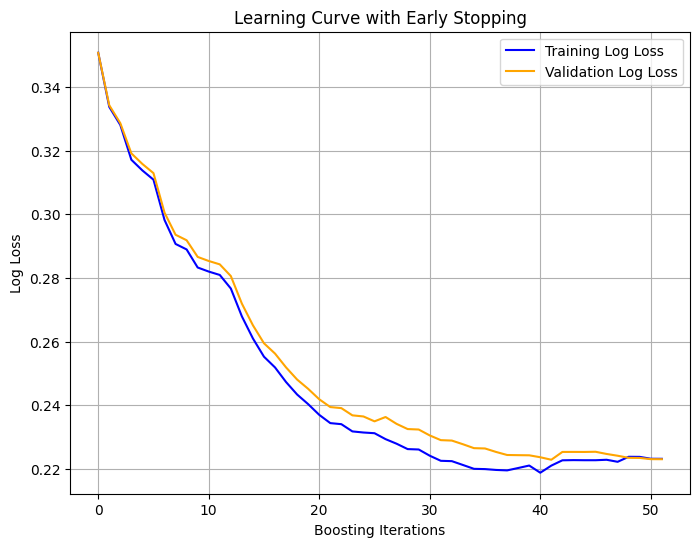

In [17]:
# making sure the metric is set to 'binary_logloss' in the parameters
best_params_lgb['metric'] = 'binary_logloss'

# datasets
dtrain = lgb.Dataset(X_train_selected, label=y_train)
dval = lgb.Dataset(X_test_selected, label=y_test)

# Callback to track evaluation metrics
evals_result = {}  # Dictionary to store log loss metrics

# Training our model with callbacks
model = lgb.train(
    params=best_params_lgb,
    train_set=dtrain,
    num_boost_round=200,
    valid_sets=[dtrain, dval],
    valid_names=['Train', 'Validation'],
    callbacks=[
        lgb.record_evaluation(evals_result),  # Storing evaluation metrics
        lgb.early_stopping(stopping_rounds=10)  # Early stopping callback
    ],
)

# training and validation losses
train_losses = evals_result['Train']['binary_logloss']
validation_losses = evals_result['Validation']['binary_logloss']

# earning curve
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Log Loss', color='blue')
plt.plot(validation_losses, label='Validation Log Loss', color='orange')
plt.xlabel('Boosting Iterations')
plt.ylabel('Log Loss')
plt.title('Learning Curve with Early Stopping')
plt.legend(loc='best')
plt.grid()
plt.show()


The learning curve shows a steady decline in log loss for both the training and validation datasets across boosting iterations. Initially, the log loss decreases rapidly, reflecting significant improvements in model performance. After approximately 30 iterations, the validation loss begins to stabilize, suggesting the model is approaching its optimal performance. The validation and training curves remain closely aligned throughout the iterations, indicating minimal overfitting. Early stopping was applied at 50 iterations when no further improvements in validation loss were observed, ensuring a balanced and well-generalized model.

### Confusion matrix

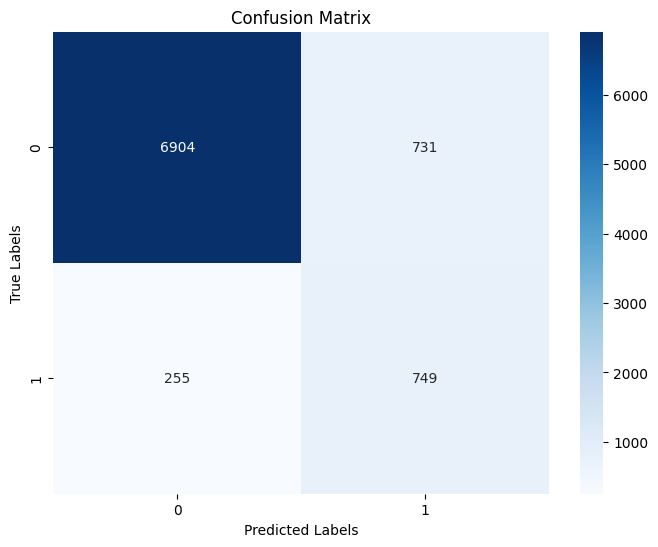

In [18]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred_selected)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=5.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=0.7 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
Test AUC: 0.9226


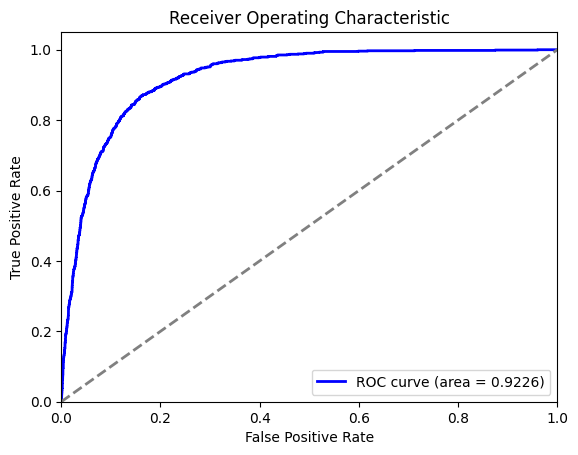

In [19]:
# Predicting probabilities for the Class 1 (yes)
y_test_proba_lgb = best_model_lgb_selected.predict_proba(X_test_selected)[:, 1]

# ROC AUC score
test_auc = roc_auc_score(y_test, y_test_proba_lgb)

print(f"Test AUC: {test_auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba_lgb)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Summary

Following feature selection and hyperparameter tuning, the model demonstrates a balanced performance between precision and recall, particularly for subscribers ("Yes"). The overall accuracy stands at 89%, showcasing the model's robustness despite the class imbalance. The precision for "Yes" is 51%, indicating moderate confidence in the model's predictions for subscribers, though false positives are present. The recall for "Yes" is 75%, showing that the model effectively identifies the majority of actual subscribers, which is crucial for targeting valuable leads. For non-subscribers ("No"), the model performs exceptionally well, achieving a precision of 96% and a recall of 90%, ensuring most non-subscribers are correctly classified. The AUC score highlights the model's strong ability to differentiate between the two classes.

The learning curve further emphasizes that the model trains effectively. Training loss steadily decreases, reflecting consistent performance improvement. Validation loss initially follows the same trend but stabilizes around iteration 50, where early stopping is applied to mitigate overfitting. This approach ensures the model generalizes well to unseen data, balancing performance on both training and validation sets. While the model excels in identifying non-subscribers, improving precision for subscribers remains an important focus to reduce false positives and enhance overall campaign efficiency.